In [1]:
from PIL import Image, ImageDraw, ImageFont, ImageTk
from IPython.display import display
from camelup import camelup, config
from glob import glob

In [2]:
game = camelup.Game(3)

camel_dict = {
    "white": {"height":1, "space":3, "need_roll": True},
    "red": {"height": 2, "space": 3, "need_roll": True},
    "blue": {"height": 3, "space": 3, "need_roll": True},
    "green": {"height": 1, "space": 16, "need_roll": True},
    "yellow": {"height": 4, "space": 3, "need_roll": True},
}
game.camel_dict = camel_dict

tiles_dict = {
    1:{"tile_type":"block","owner":1}
}
game.tiles_dict = tiles_dict

In [3]:
img = Image.new('RGB', (500, 500), color = (236,192,81))
img.save('camel.png')

In [4]:
font = ImageFont.truetype("../fonts/arial.ttf", 9)
board_info = dict()
draw = ImageDraw.Draw(img)
border = 5
width = (img.size[0]-border*2)/5
height = (img.size[1]-border*2)/5
space = 1
top_left_corner = (border,border)
bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
board_info[space]=(top_left_corner,bottom_right_corner)
space += 1
for i in range(4):
    top_left_corner = (top_left_corner[0] + width, top_left_corner[1])
    bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
    draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
    draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
    board_info[space]=(top_left_corner,bottom_right_corner)
    space +=1
for i in range(4):
    top_left_corner = (top_left_corner[0], top_left_corner[1]+ height)
    bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
    draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
    draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
    board_info[space]=(top_left_corner,bottom_right_corner)
    space +=1
for i in range(4):
    top_left_corner = (top_left_corner[0] - width, top_left_corner[1])
    bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
    draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
    draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
    board_info[space]=(top_left_corner,bottom_right_corner)
    space +=1
for i in range(3):
    top_left_corner = (top_left_corner[0], top_left_corner[1]- height)
    bottom_right_corner = (top_left_corner[0] + width, top_left_corner[1] + height)
    draw.rectangle([top_left_corner, bottom_right_corner], fill = (251,207,41), outline = (29,29,29))
    draw.text((top_left_corner[0]+2, top_left_corner[1]+2), str(space), font=font, fill=(0,0,0))
    board_info[space]=(top_left_corner,bottom_right_corner)
    space +=1   
draw.text((120, 340), 'To Be Rolled', font=font, fill=(0,0,0))

bet_str = 'Bet Tiles (Colour - Value)'
for key, val in game.bet_tiles.items():
    bet_str += f'\n{key} - {val[0]}'
draw.text((120, 120), bet_str, font=font, fill=(0,0,0))   
    
player_str = 'Player Items'
for key, val in game.player_dict.items():
    player_str += f'\nPlayer: {key} Coins: {val["coins"]} Bet Tiles: '
    for tile, bets in game.player_dict[key]['bet_tiles'].items():
        player_str += f'{tile[0]}('
        player_str += ', '.join(str(x) for x in bets)
        player_str += ') '
draw.text((120, 220), player_str, font=font, fill=(0,0,0))

game_str = f'Winner Bets: {len(game.winner_bets)}\nLoser Bets: {len(game.winner_bets)}'
draw.text((300, 120), game_str, font=font, fill=(0,0,0))

In [5]:
def open_camel(file):
    camel = Image.open(file)
    transparency = Image.new('RGBA', camel.size, (0, 0, 0, 0))
    transparency.paste(camel, (0,0))
    per = 0.1
    wsize = int(transparency.size[0]*per)
    hsize = int(transparency.size[1]*per)
    return transparency.resize((wsize,hsize), Image.ANTIALIAS)
    

In [6]:
def place_camel_dict(game, board_info):
    counter = 0
    for camel, values in camel_dict.items():
        file = glob(f'../img/*{camel}*')[0]
        pic = open_camel(file)
        square = board_info[values['space']]
        x = int(square[0][0] + width/2-(pic.size[0]/2))
        y = int(square[1][1] - pic.size[0] - ((values['height']-1)*14))
        img.paste(pic, (x,y), mask = pic)
        if values['need_roll']:
            x = 120 + counter*35 
            y = 350
            img.paste(pic, (x,y), mask = pic)
            counter +=1

In [7]:
def place_tiles(game,board_info):
    for space, val in game.tiles_dict.items():
        tile = board_info[space]
        top_left_corner = (tile[0][0]+10,tile[0][1]+10)
        bottom_right_corner = (tile[1][0]-10,tile[1][1]-10)
        draw.rectangle([top_left_corner, bottom_right_corner], fill = (255,225,255), outline = (29,29,29))
        draw.text((tile[0][0]+25, tile[0][1]+35), val['tile_type'], font=font, fill=(0,0,0))
    

In [8]:
place_camel_dict(game,board_info)
place_tiles(game,board_info)

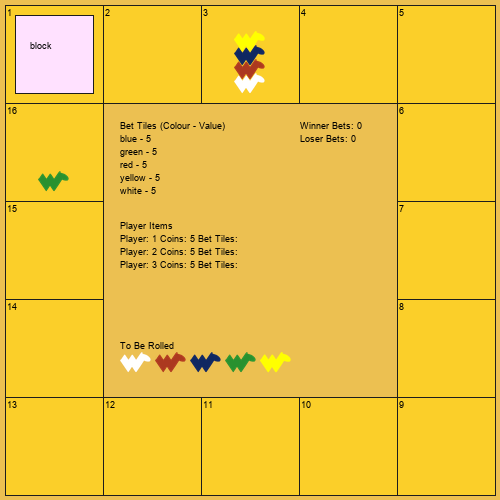

In [9]:
img

In [10]:
from tkinter import *
from tkinter import ttk

In [11]:
def play(event):
    print(combo.get())
    game.play(game.available_moves()[combo.get()])

In [12]:
root = Toplevel()
root.title("Test")
mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)


combo = ttk.Combobox(mainframe, 
                values=list(game.available_moves().keys()))
combo.grid(column = 1, row = 0)
combo.current(0)


label = Label(mainframe)
label.img = ImageTk.PhotoImage(img)
label.config(image=label.img)
label.grid(column = 0, row = 0)

combo.bind("<<ComboboxSelected>>", play)
root.mainloop()



Bet Game Winner yellow
Place Skip Tile At 15


In [14]:
game.tiles_dict

{1: {'tile_type': 'block', 'owner': 1}, 15: {'tile_type': 'skip', 'player': 2}}